In [180]:
import pylab
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import transbigdata as tbd
import datetime
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf         # 自相关图、偏自相关图
from statsmodels.tsa.stattools import adfuller as ADF                # 平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox              # 白噪声检验
import statsmodels.api as sm                                         # D-W检验,一阶自相关检验
from statsmodels.graphics.api import qqplot                          # 画QQ图,检验一组数据是否服从正态分布
from statsmodels.tsa.arima_model import ARIMA
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams['axes.unicode_minus'] = False
#%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [181]:
train = pd.read_csv('./march_hello.csv')
dt = train["StartTime"]
dt = dt.apply(lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))
train["start_month"] = dt.map(lambda x: x.month)
train["start_day"] = dt.map(lambda x: x.day)
train["start_year"] = dt.map(lambda x: x.year)
train["start_time"] = pd.PeriodIndex(year=train["start_year"], month=train["start_month"], day=train["start_day"], freq="D")
et = train["EndTime"]
et = et.apply(lambda y: datetime.strptime(y, '%Y/%m/%d %H:%M:%S'))
train["end_month"] = et.map(lambda x: x.month)
train["end_day"] = et.map(lambda x: x.day)
train["end_year"] = et.map(lambda x: x.year)
train["end_time"] = pd.PeriodIndex(year=train["end_year"], month=train["end_month"], day=train["end_day"], freq="D")

# 把原有的类型变量对应的特征去掉，将一些不相关的特征去掉
fields_to_drop = ['Title','CompanyId','StartTime','EndTime', 'AverageSpeed', 'id', 'name', 'location', 'pname', 'pcode', 'cityname', 'citycode', 'adcode', 'address', 'type', 'typecode', 'gridcode', 'entr_location', 'tel', 'postcode', 'tag','longitude', 'latitude', 'functionaltype', 'trafficaccessibility', 'start_year', 'start_month', 'start_day', 'end_year', 'end_month', 'end_day','adname','TimePeriod','Distance']
data = train.drop(fields_to_drop, axis=1)
data

,BicycleNo,OrderId,StartLongitude,StartLatitude,EndLongitude,EndLatitude,start_time,end_time
0,1,1,121.558125,29.854842,121.552669,29.867710,2021-03-01,2021-03-01
1,2,2,121.554929,29.833805,121.560528,29.825347,2021-03-01,2021-03-01
2,3,3,121.578817,29.876072,121.573239,29.861707,2021-03-01,2021-03-01
3,4,4,121.588562,29.858032,121.564185,29.862697,2021-03-01,2021-03-01
4,5,5,121.576435,29.855785,121.564159,29.820986,2021-03-01,2021-03-01
...,...,...,...,...,...,...,...,...
438613,1524,438614,121.593130,29.854728,121.586124,29.859913,2021-03-31,2021-03-31
438614,10244,438615,121.545438,29.858008,121.542593,29.840971,2021-03-31,2021-03-31
438615,10044,438616,121.551685,29.869674,121.559331,29.876717,2021-03-31,2021-03-31
438616,1677,438617,121.572378,29.852332,121.562266,29.853573,2021-03-31,2021-03-31


In [182]:
max(data.StartLongitude)
min(data.StartLongitude)
max(data.EndLatitude)
min(data.EndLatitude)

121.658294

121.257092

37.549171

29.720824

In [183]:
ningbo_admin = gpd.read_file(r'./ningbo.json')
data = tbd.clean_outofshape(data, ningbo_admin, col=['StartLongitude', 'StartLatitude'], accuracy=500)

In [184]:
bounds = ( 121.257092, 29.720824,121.658294,37.549171)
params = tbd.grid_params(bounds,accuracy = 500)
#集计OD
data['LONCOL'],data['LATCOL'] = tbd.GPS_to_grids(data['StartLongitude'],data['StartLatitude'],params)
# od_gdf = tbd.odagg_grid(bikedata, params, col=['StartLongitude','StartLatitude', 'EndLongitude','EndLatitude'])
# od_gdf.head()
data

,BicycleNo,OrderId,StartLongitude,StartLatitude,EndLongitude,EndLatitude,start_time,end_time,LONCOL,LATCOL
0,1,1,121.558125,29.854842,121.552669,29.867710,2021-03-01,2021-03-01,56,30
1,77,77,121.562511,29.854511,121.560953,29.809304,2021-03-01,2021-03-01,57,30
2,22,226,121.562398,29.854184,121.567581,29.862070,2021-03-01,2021-03-01,57,30
3,408,408,121.562234,29.856905,121.572958,29.860967,2021-03-01,2021-03-01,56,30
4,825,825,121.558419,29.854999,121.567367,29.855928,2021-03-01,2021-03-01,56,30
...,...,...,...,...,...,...,...,...,...,...
438599,4649,425994,121.625920,29.868162,121.620078,29.858527,2021-03-31,2021-03-31,68,33
438600,3460,427055,121.521573,29.870614,121.537134,29.867026,2021-03-31,2021-03-31,49,33
438601,5104,430012,121.519814,29.868067,121.566135,29.869381,2021-03-31,2021-03-31,49,33
438602,1954,432038,121.507379,29.845216,121.513029,29.850964,2021-03-31,2021-03-31,46,28


In [185]:
#把起终点的经纬度栅格编号变为一个字段
data['S'] = data['LONCOL'].astype(str) + ',' + data['LATCOL'].astype(str)
#提取节点集合
data
node = set(data['S'])
#把节点集合变成DataFrame
node = pd.DataFrame(node)
#重新编号节点
node['id'] = range(len(node))
node['S']=node[0]
fields_to_drop = [0]
node= node.drop(fields_to_drop, axis=1)
node

,BicycleNo,OrderId,StartLongitude,StartLatitude,EndLongitude,EndLatitude,start_time,end_time,LONCOL,LATCOL,S
0,1,1,121.558125,29.854842,121.552669,29.867710,2021-03-01,2021-03-01,56,30,"56,30"
1,77,77,121.562511,29.854511,121.560953,29.809304,2021-03-01,2021-03-01,57,30,"57,30"
2,22,226,121.562398,29.854184,121.567581,29.862070,2021-03-01,2021-03-01,57,30,"57,30"
3,408,408,121.562234,29.856905,121.572958,29.860967,2021-03-01,2021-03-01,56,30,"56,30"
4,825,825,121.558419,29.854999,121.567367,29.855928,2021-03-01,2021-03-01,56,30,"56,30"
...,...,...,...,...,...,...,...,...,...,...,...
438599,4649,425994,121.625920,29.868162,121.620078,29.858527,2021-03-31,2021-03-31,68,33,"68,33"
438600,3460,427055,121.521573,29.870614,121.537134,29.867026,2021-03-31,2021-03-31,49,33,"49,33"
438601,5104,430012,121.519814,29.868067,121.566135,29.869381,2021-03-31,2021-03-31,49,33,"49,33"
438602,1954,432038,121.507379,29.845216,121.513029,29.850964,2021-03-31,2021-03-31,46,28,"46,28"


,id,S
0,0,"43,35"
1,1,"67,33"
2,2,"61,34"
3,3,"55,38"
4,4,"61,40"
...,...,...
451,451,"61,10"
452,452,"63,39"
453,453,"54,25"
454,454,"61,33"


In [186]:
#把新编号连接到OD数据上
data = pd.merge(data,node,on=['S'])
data.head()

,BicycleNo,OrderId,StartLongitude,StartLatitude,EndLongitude,EndLatitude,start_time,end_time,LONCOL,LATCOL,S,id
0,1,1,121.558125,29.854842,121.552669,29.867710,2021-03-01,2021-03-01,56,30,"56,30",225
1,408,408,121.562234,29.856905,121.572958,29.860967,2021-03-01,2021-03-01,56,30,"56,30",225
2,825,825,121.558419,29.854999,121.567367,29.855928,2021-03-01,2021-03-01,56,30,"56,30",225
3,958,958,121.558514,29.855144,121.564770,29.851917,2021-03-01,2021-03-01,56,30,"56,30",225
4,102,1145,121.558438,29.855052,121.566104,29.869219,2021-03-01,2021-03-01,56,30,"56,30",225


In [187]:
fields_to_drop = ['end_time','LONCOL','LATCOL']
data = data.drop(fields_to_drop, axis=1)
data


,BicycleNo,OrderId,StartLongitude,StartLatitude,EndLongitude,EndLatitude,start_time,S,id
0,1,1,121.558125,29.854842,121.552669,29.867710,2021-03-01,"56,30",225
1,408,408,121.562234,29.856905,121.572958,29.860967,2021-03-01,"56,30",225
2,825,825,121.558419,29.854999,121.567367,29.855928,2021-03-01,"56,30",225
3,958,958,121.558514,29.855144,121.564770,29.851917,2021-03-01,"56,30",225
4,102,1145,121.558438,29.855052,121.566104,29.869219,2021-03-01,"56,30",225
...,...,...,...,...,...,...,...,...,...
438599,839,412540,121.521553,29.864958,121.537408,29.874104,2021-03-29,"49,32",424
438600,245,403863,121.535442,29.765304,121.527871,29.771081,2021-03-29,"52,10",237
438601,4649,425994,121.625920,29.868162,121.620078,29.858527,2021-03-31,"68,33",61
438602,1954,432038,121.507379,29.845216,121.513029,29.850964,2021-03-31,"46,28",282


In [190]:
outputpath='grid.csv'
data.to_csv(outputpath,sep=',',columns=['BicycleNo','OrderId','StartLongitude','StartLatitude','EndLongitude','EndLatitude','start_time','S','id'])

In [37]:
data.isnull().sum()


BicycleNo         0
OrderId           0
StartLongitude    0
StartLatitude     0
EndLongitude      0
EndLatitude       0
TimePeriod        0
Distance          0
adname            0
start_time        0
end_time          0
dtype: int64

In [5]:
groups = data.groupby(['adname','start_time']).count()
groups.head()

BicycleNo  OrderId  StartLongitude  StartLatitude  \
adname start_time                                                      
江北区    2021-03-01        265      265             265            265   
       2021-03-02        482      482             482            482   
       2021-03-03        469      469             469            469   
       2021-03-04        601      601             601            601   
       2021-03-05        413      413             413            413   

                   EndLongitude  EndLatitude  TimePeriod  Distance  end_time  
adname start_time                                                             
江北区    2021-03-01           265          265         265       265       265  
       2021-03-02           482          482         482       482       482  
       2021-03-03           469          469         469       469       469  
       2021-03-04           601          601         601       601       601  
       2021-03-05           413          413         413       413       413

In [6]:
outputpath='everyday_everyad.csv'
groups.to_csv(outputpath,sep=',',columns=['BicycleNo'])

,adname,start_time,BicycleNo
0,江北区,2021-03-01,265
1,江北区,2021-03-02,482
2,江北区,2021-03-03,469
3,江北区,2021-03-04,601
4,江北区,2021-03-05,413


,adname,start_time,BicycleNo
26,江北区,2021-03-27,502
27,江北区,2021-03-28,427
28,江北区,2021-03-29,645
29,江北区,2021-03-30,451
30,江北区,2021-03-31,525


,BicycleNo
start_time,
2021-03-01,265
2021-03-02,482
2021-03-03,469
2021-03-04,601
2021-03-05,413


<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='start_time'>

<Figure size 720x360 with 0 Axes>

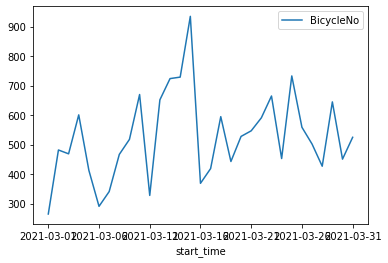

In [7]:
adday= pd.read_csv('./everyday_everyad.csv')
adday.head()
x = adday[adday['adname'] == '江北区']
x.tail()
outputpath='1.csv'
x.to_csv(outputpath,sep=',',columns=['start_time','BicycleNo'])
jiangbei= pd.read_csv('./1.csv',index_col='start_time')
jiangbei_drop = ['Unnamed: 0']
jiangbei = jiangbei.drop(jiangbei_drop, axis=1)
jiangbei.head()
plt.figure(figsize=(10,5))
jiangbei.plot()
plt.show()

/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2787277042.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(jiangbei, lags=30).show()
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2787277042.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(jiangbei, lags=14).show()


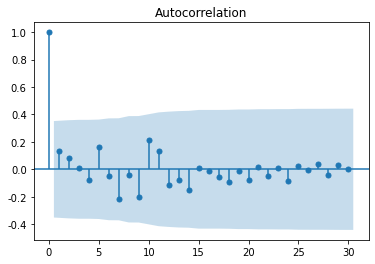

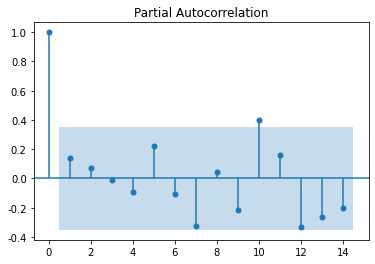

In [8]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf         # 自相关图、偏自相关图
plot_acf(jiangbei, lags=30).show()
plot_pacf(jiangbei, lags=14).show()

In [9]:
from statsmodels.tsa.stattools import adfuller as ADF                # 平稳性检验
from statsmodels.stats.diagnostic import acorr_ljungbox              # 白噪声检验
print('原始序列的ADF检验结果为：',ADF(jiangbei.BicycleNo))
#-4.901578959578711 比  -3.6699197407407405 小 在99%的置信区间拒绝原假设 证明数据平稳 不存在单位根
#因此使用ARIMA(p,0,q)模型
print('原序列的白噪声检验结果为：',acorr_ljungbox(jiangbei,lags=1,return_df = bool))#返回统计量、P值
##解读：p值大于0.05，无法拒绝原假设（纯随机序列），说明原序列是白噪声序列。（无法用时间序列进行预测）

原始序列的ADF检验结果为： (-4.901578959578711, 3.4628398139475796e-05, 0, 30, {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}, 271.75547018827604)
原序列的白噪声检验结果为：     lb_stat  lb_pvalue
1  0.610193   0.434715


<Figure size 720x360 with 0 Axes>

<AxesSubplot:xlabel='start_time'>

<Figure size 720x360 with 0 Axes>

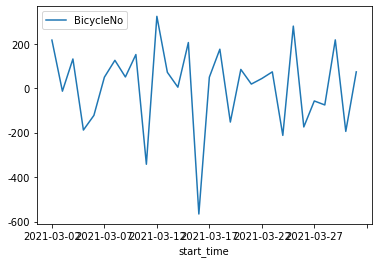

原始序列的ADF检验结果为： (-5.590250604577588, 1.3341530488463437e-06, 1, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, 266.0226646720048)


/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/3395850394.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(d1_jb, lags=29).show()


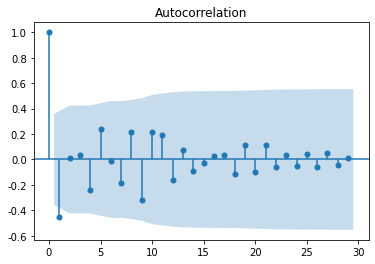

In [10]:
#一阶差分
d1_jb = jiangbei.diff(periods=1, axis=0).dropna()
 
#时序图
plt.figure(figsize=(10,5))
d1_jb.plot()
plt.show()
#解读：在均值附件比较平稳波动
 
#自相关图
plot_acf(d1_jb, lags=29).show()
#解读：有短期相关性，但趋向于零。
 
#平稳性检验
print('原始序列的ADF检验结果为：',ADF(d1_jb.BicycleNo))
 
#解读：P值小于显著性水平α（0.05），拒绝原假设（非平稳序列），说明一阶差分序列是平稳序列。

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox              # 白噪声检验
print('一阶差分序列的白噪声检验结果为：',acorr_ljungbox(d1_jb,lags=1,return_df = bool))#返回统计量、P值
#解读：p值小于0.05，拒绝原假设（纯随机序列) 说明一阶差分序列是非白噪声序列。

一阶差分序列的白噪声检验结果为：     lb_stat  lb_pvalue
1  6.715396   0.009558


/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/1857707999.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(d1_jb, lags=29).show()
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/1857707999.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(d1_jb, lags=10).show()
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/1857707999.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(d1_jb, lags=14).show()


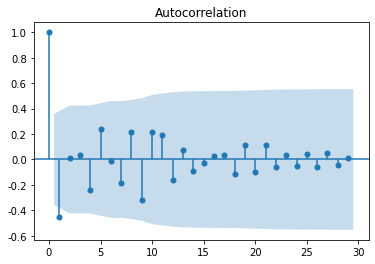

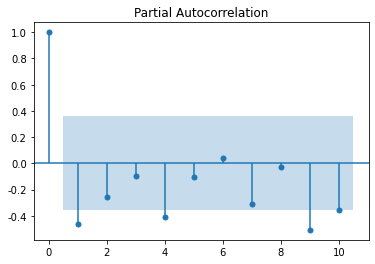

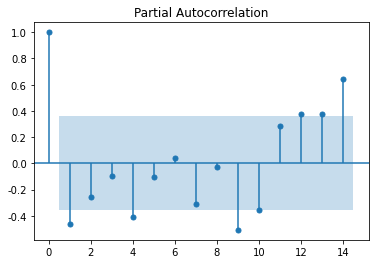

In [12]:
#定阶
d1_jb = jiangbei.diff(periods=1, axis=0).dropna()
 
#自相关图
plot_acf(d1_jb, lags=29).show()
 
#解读：有短期相关性，但趋向于零。
 
#偏自相关图
plot_pacf(d1_jb, lags=10).show()
 
 
#偏自相关图
plot_pacf(d1_jb, lags=14).show()
 
#解读：自相关图，1阶截尾；偏自相关图，同样为1阶截尾。

In [13]:
from statsmodels.tsa.arima_model import ARIMA

In [14]:
#bic矩阵
pmax = int(len(jiangbei)/10)
qmax = int(len(jiangbei)/10)
bic_matrix = []
for p in range(pmax+1):
    tmp = []
    for q in range(qmax+1):
        try:
            tmp.append(ARIMA(d1_jb,(p,1,q)).fit().bic)
        except:
            tmp.append(None)
bic_matrix.append(tmp)
#从中找出最小值
bic_matrix = pd.DataFrame(bic_matrix)
#先用stack展平，然后用idmin找出最小值位置
p,q = bic_matrix.stack().astype('float64').idxmin()
print(u'BIC最小的p值和q值为：%s、%s'%(p,q))
#BIC最小的p值和q值为：0、1

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, s

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20217D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   7.202D+00
  F =   7.2021722803135546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76544D+00    |proj g|=  7.77174D-03

At iterate    5    f=  6.73271D+00    |proj g|=  7.11431D-05

At iterate   10    f=  6.73268D+00    |proj g|=  4.08562D-06

At iterate   15    f=  6.73268D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     22      1     0     0   1.776D-07   6.733D+00
  F =   6.7326751584967006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency informat


At iterate   30    f=  6.52211D+00    |proj g|=  7.81597D-06

At iterate   35    f=  6.52211D+00    |proj g|=  5.68434D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     68      2     0     0   5.684D-06   6.522D+00
  F =   6.5221073022670293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92273D+00    |proj g|=  5.95213D-03

At iterate    5    f=  6.92261D+00    |proj g|=  2.42650D-04

At iter

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/pyth

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65129D+00    |proj g|=  4.41542D-02

At iterate    5    f=  6.60712D+00    |proj g|=  5.22289D-02

At iterate   10    f=  6.60125D+00    |proj g|=  6.21725D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   0.000D+00   6.601D+00
  F =   6.6012541191113279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [15]:
#AIC
# jiangbei.head()
pmax = int(len(d1_jb)/ 10) #一般阶数不超过length/10
qmax = int(len(d1_jb) / 10) #一般阶数不超过length/10
aic_matrix = []
for p in range(pmax + 1):
    tmp = []
    for q in range(qmax + 1):
        try:
            tmp.append(ARIMA(jiangbei,order=(p, 1, q)).fit().aic)
        except:
            tmp.append(None)
    aic_matrix.append(tmp)
aic_matrix = pd.DataFrame(aic_matrix)
p,q = aic_matrix.stack().astype('float64').idxmin() #最小值的索引)
print(u'AIC最小的p值和q值为：%s、%s'%(p,q))
#AIC最小的p值和q值为：0、1

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.

   

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66057D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   6.661D+00
  F =   6.6605720011612233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred fr


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   8.882D-08   6.432D+00
  F =   6.4316068454491937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51437D+00    |proj g|=  6.24460D-03

At iterate    5    f=  6.51429D+00    |proj g|=  1.40803D-03

At iterate   10    f=  6.51387D+00    |proj g|=  5.26876D-03

At iterate   15    f=  6.51381D+00    |proj g|=  8.88178D-08

       

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Use

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43373D+00    |proj g|=  2.44500D-02

At iterate    5    f=  6.42682D+00    |proj g|=  7.56195D-04

At iterate   10    f=  6.42673D+00    |proj g|=  1.77636D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   8.882D-08   6.427D+00
  F =   6.4267262181535854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodel


At iterate    5    f=  6.45280D+00    |proj g|=  1.04659D-02

At iterate   10    f=  6.43092D+00    |proj g|=  2.62261D-03

At iterate   15    f=  6.43090D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     17      1     0     0   1.776D-07   6.431D+00
  F =   6.4308986088979028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49423D+00    |proj g|=  8.93018D-02

At iter

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/py

In [16]:
#创建模型
model = ARIMA(jiangbei, (4, 1, 4)).fit()
#查看模型报告
model.summary2()

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53423D+00    |proj g|=  2.31029D-01

At iterate    5    f=  6.43130D+00    |proj g|=  1.70908D-01

At iterate   10    f=  6.41671D+00    |proj g|=  1.05782D-02

At iterate   15    f=  6.40198D+00    |proj g|=  3.30206D-02

At iterate   20    f=  6.39844D+00    |proj g|=  1.02241D-02

At iterate   25    f=  6.39780D+00    |proj g|=  3.38041D-03

At iterate   30    f=  6.39778D+00    |proj g|=  8.15170D-03

At iterate   35    f=  6.39693D+00    |proj g|=  3.42880D-02


 This problem is unconstrained.



At iterate   40    f=  6.39576D+00    |proj g|=  2.91358D-03

At iterate   45    f=  6.39557D+00    |proj g|=  2.60911D-03

At iterate   50    f=  6.39557D+00    |proj g|=  3.01981D-05

At iterate   55    f=  6.39557D+00    |proj g|=  2.93099D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     59     70      1     0     0   3.553D-07   6.396D+00
  F =   6.3955667907536187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARIMA
====================================================================
Model:              ARIMA            BIC:                 417.7460  
Dependent Variable: D.BicycleNo      Log-Likelihood:      -191.87   
Date:               2022-03-28 19:13 Scale:               1.0000    
No. Observations:   30               Method:              css-mle   
Df Model:           9                Sample:              03-02-2021
Df Residuals:       21                                    03-31-2021
Converged:          1.0000           S.D. of innovations: 131.665   
No. Iterations:     59.0000          HQIC:                408.217   
AIC:                403.7340                                        
--------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------
const                 4.2770   2.9792  1.4356 0.1511 -1.5621 10.1162
ar.L1.D.BicycleNo    -0.2393   0.6719 -0.3561 0.7217 -1.5561  1.0775
ar.L2.D.BicycleNo    -0.6087   0.3918 -1.5534 0.1203 -1.3767  0.1593
ar.L3.D.BicycleNo    -0.5981   0.6050 -0.9886 0.3228 -1.7839  0.5877
ar.L4.D.BicycleNo    -0.0645   0.2122 -0.3039 0.7612 -0.4803  0.3514
ma.L1.D.BicycleNo    -0.6473   0.6738 -0.9607 0.3367 -1.9679  0.6733
ma.L2.D.BicycleNo     0.4008   0.8881  0.4512 0.6518 -1.3400  2.1415
ma.L3.D.BicycleNo    -0.0502   0.8991 -0.0558 0.9555 -1.8124  1.7120
ma.L4.D.BicycleNo    -0.7033   0.6611 -1.0639 0.2874 -1.9989  0.5924
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            0.2725            -1.0302           1.0656            -0.2088
AR.2            0.2725             1.0302           1.0656             0.2088
AR.3           -1.6768            -0.0000           1.6768            -0.5000
AR.4           -8.1455            -0.0000           8.1455            -0.5000
MA.1            1.0000            -0.0000           1.0000            -0.0000
MA.2            0.1753            -0.9845           1.0000            -0.2220
MA.3            0.1753             0.9845           1.0000             0.2220
MA.4           -1.4219            -0.0000           1.4219            -0.5000
====================================================================

"""

/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2103111911.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(resid, lags=29).show()
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2103111911.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(resid, lags=10).show()
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2103111911.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(resid, lags=14).show()


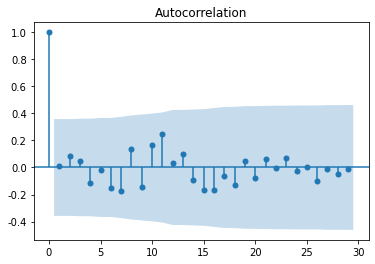

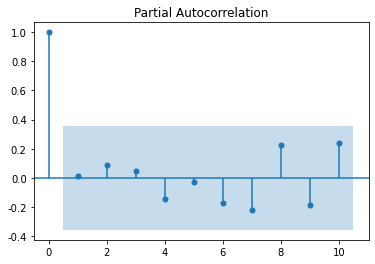

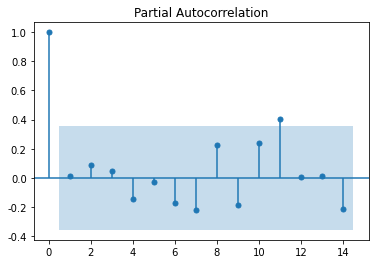

In [17]:
resid = model.resid
 
#自相关图
plot_acf(resid, lags=29).show()
 
#解读：有短期相关性，但趋向于零。
 
#偏自相关图
plot_pacf(resid, lags=10).show()
 
#偏自相关图
plot_pacf(resid, lags=14).show()

/Users/monica/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/var/folders/xz/pq8gxmqj4gxdlzj115m49wkw0000gn/T/ipykernel_66094/2084907783.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  qqplot(resid, line='q', fit=True).show()


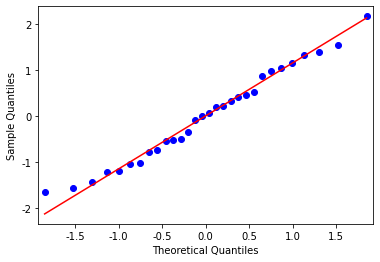

In [18]:
qqplot(resid, line='q', fit=True).show() 
 
#解读：残差服从正态分布，均值为零，方差为常数

In [19]:
print('D-W检验的结果为：',sm.stats.durbin_watson(resid.values))  
#DW＝２ ＜＝＞ ρ＝０　　即不存在（一阶）自相关性
#解读：不存在一阶自相关

D-W检验的结果为： 1.8618000567945656


In [20]:
# 方法一
print('残差序列的白噪声检验结果为：',acorr_ljungbox(resid,lags=1,return_df = bool))#返回统计量、P值
 
#解读：残差是白噪声

残差序列的白噪声检验结果为：     lb_stat  lb_pvalue
1  0.004151    0.94863


In [21]:
model.forecast(1)

(array([623.42896855]),
 array([131.6654977]),
 array([[365.36933505, 881.48860204]]))

In [22]:
forecast = pd.Series(model.forecast(30)[0], index=pd.date_range('2021-3-2', periods=30, freq='D'))
forecast

2021-03-02    623.428969
2021-03-03    626.688740
2021-03-04    631.250776
2021-03-05    592.074753
2021-03-06    601.113212
2021-03-07    630.595619
2021-03-08    651.916438
2021-03-09    636.726751
2021-03-10    619.903643
2021-03-11    629.258697
2021-03-12    655.709224
2021-03-13    665.465971
2021-03-14    653.258092
2021-03-15    644.553583
2021-03-16    657.263593
2021-03-17    676.931705
2021-03-18    681.220774
2021-03-19    671.919335
2021-03-20    669.688099
2021-03-21    682.787902
2021-03-22    697.036577
2021-03-23    698.325726
2021-03-24    692.390319
2021-03-25    694.396207
2021-03-26    706.577135
2021-03-27    716.646608
2021-03-28    716.743575
2021-03-29    713.913695
2021-03-30    718.461218
2021-03-31    729.126259
Freq: D, dtype: float64

<Figure size 720x360 with 0 Axes>

<AxesSubplot:>

<Figure size 720x360 with 0 Axes>

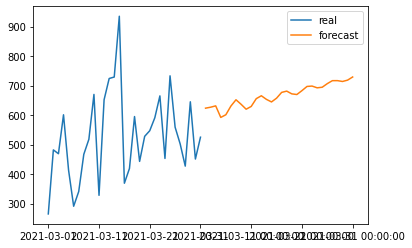

In [23]:
data = pd.concat((jiangbei, forecast), axis=0)
data.columns = ['real', 'forecast']
plt.figure(figsize = (10,5))
data.plot()
plt.show()